# 1 

A partir del fichero "US_Crime_Rates_1960_2014", se pide:

1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.
2. Dibujar todas las columnas numéricas.
3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas. 
4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación? 
5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.
6. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y batches = 7.

In [4]:
import os, sys  

sys.path.append("C:\\Users\\Roxan\\OneDrive\\Documentos\\My_map_2\\Data-science-bootcamp")

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plot

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

import pickle

from Utils import my_functions

import warnings
warnings.filterwarnings('ignore')

1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.

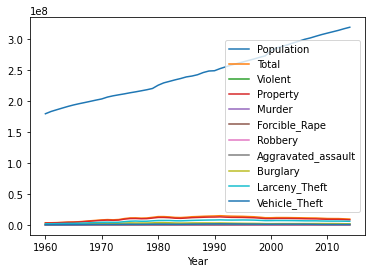

In [6]:
df = pd.read_csv("../data/US_Crime_Rates_1960_2014.csv")

df.set_index("Year", inplace=True)
df.plot()

2. Dibujar todas las columnas numéricas.

In [9]:
df.info() #all columns are numeric

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 1960 to 2014
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Population          55 non-null     int64
 1   Total               55 non-null     int64
 2   Violent             55 non-null     int64
 3   Property            55 non-null     int64
 4   Murder              55 non-null     int64
 5   Forcible_Rape       55 non-null     int64
 6   Robbery             55 non-null     int64
 7   Aggravated_assault  55 non-null     int64
 8   Burglary            55 non-null     int64
 9   Larceny_Theft       55 non-null     int64
 10  Vehicle_Theft       55 non-null     int64
dtypes: int64(11)
memory usage: 5.2 KB


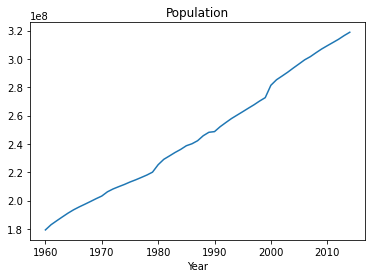

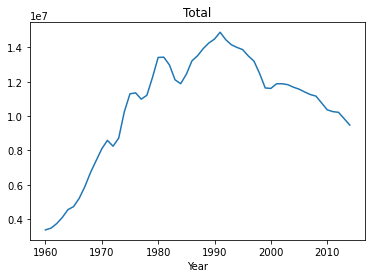

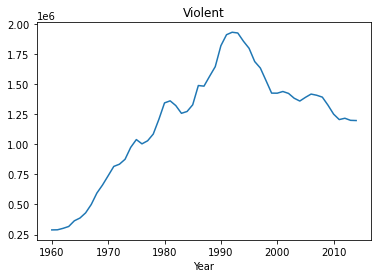

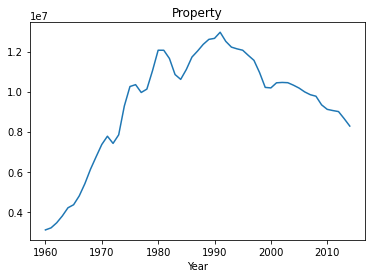

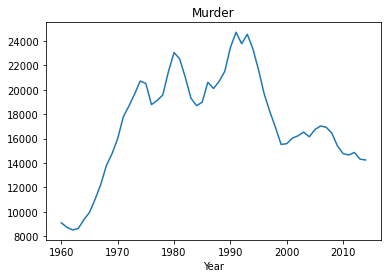

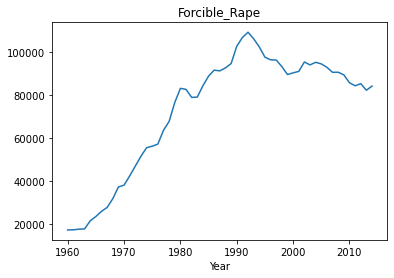

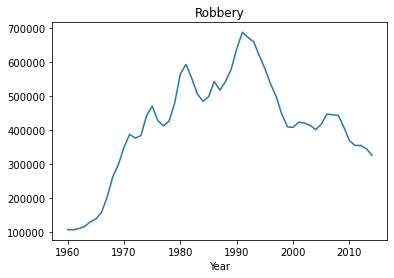

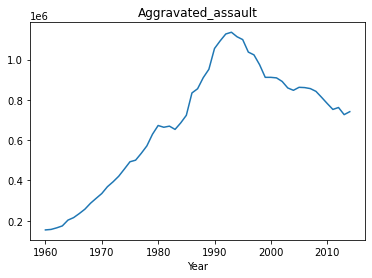

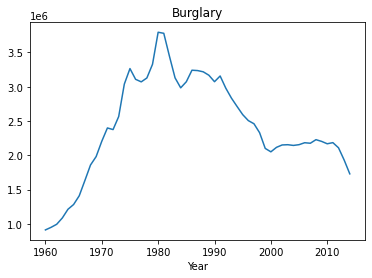

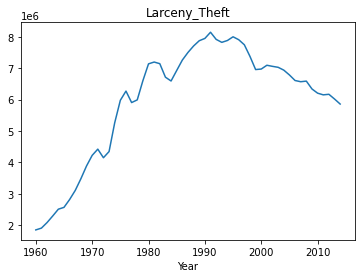

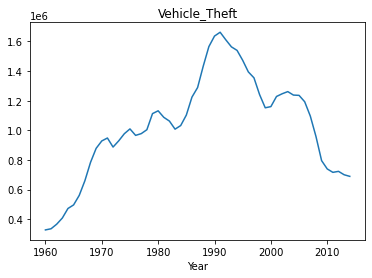

In [10]:
for i, col in enumerate(df.columns):
    df[col].plot(fig=plt.figure(i))
    plt.title(col)

plt.show()

3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas.

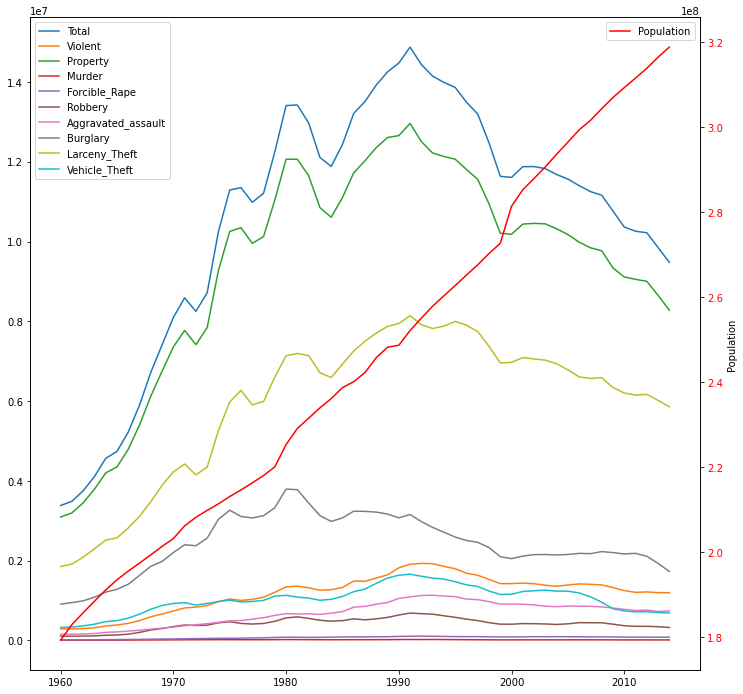

In [39]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(111)
ax1.plot(df.drop("Population", axis=1))
plt.legend(['Total', 'Violent', 'Property', 'Murder', 'Forcible_Rape',
       'Robbery', 'Aggravated_assault', 'Burglary', 'Larceny_Theft',
       'Vehicle_Theft'])

ax2 = ax1.twinx()
ax2.plot(df["Population"], 'r-')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.set_ylabel("Population")
plt.legend(["Population"], loc=0)
## how to resolve the problem with the legend? 

4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación?

In [40]:
df.drop(["Population", "Total"], axis=1, inplace=True)

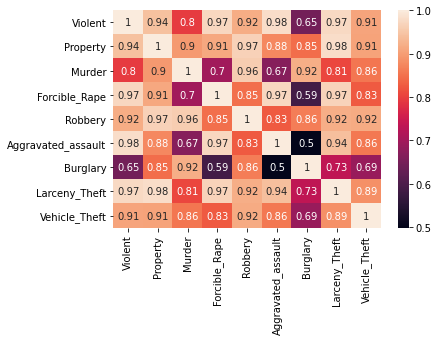

In [44]:
sns.heatmap(df.corr(), annot=True)

In [47]:
#finding highly columns that have high correlation (higher than 0.5)
df_corr = df.corr()
indices = np.where(df_corr > 0.5)
indices = [(df_corr.columns[x], df_corr.columns[y]) for x, y in zip(*indices) if x != y and x < y]
indices

[('Violent', 'Property'),
 ('Violent', 'Murder'),
 ('Violent', 'Forcible_Rape'),
 ('Violent', 'Robbery'),
 ('Violent', 'Aggravated_assault'),
 ('Violent', 'Burglary'),
 ('Violent', 'Larceny_Theft'),
 ('Violent', 'Vehicle_Theft'),
 ('Property', 'Murder'),
 ('Property', 'Forcible_Rape'),
 ('Property', 'Robbery'),
 ('Property', 'Aggravated_assault'),
 ('Property', 'Burglary'),
 ('Property', 'Larceny_Theft'),
 ('Property', 'Vehicle_Theft'),
 ('Murder', 'Forcible_Rape'),
 ('Murder', 'Robbery'),
 ('Murder', 'Aggravated_assault'),
 ('Murder', 'Burglary'),
 ('Murder', 'Larceny_Theft'),
 ('Murder', 'Vehicle_Theft'),
 ('Forcible_Rape', 'Robbery'),
 ('Forcible_Rape', 'Aggravated_assault'),
 ('Forcible_Rape', 'Burglary'),
 ('Forcible_Rape', 'Larceny_Theft'),
 ('Forcible_Rape', 'Vehicle_Theft'),
 ('Robbery', 'Aggravated_assault'),
 ('Robbery', 'Burglary'),
 ('Robbery', 'Larceny_Theft'),
 ('Robbery', 'Vehicle_Theft'),
 ('Aggravated_assault', 'Larceny_Theft'),
 ('Aggravated_assault', 'Vehicle_Theft')

5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.

In [50]:
#finding top 5 columns with highest correlation with target column: Murder
cor_target = abs(df_corr["Murder"])
cor_target.sort_values(ascending=False).head(6)

Murder           1.000000
Robbery          0.960156
Burglary         0.920207
Property         0.895641
Vehicle_Theft    0.856600
Larceny_Theft    0.806279
Name: Murder, dtype: float64

In [66]:
#Creating X, Y
X = df[["Robbery", "Burglary", "Property", "Vehicle_Theft", "Larceny_Theft"]].values
y = df["Murder"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train.shape

(44, 5)

In [61]:
#finding best parameters
new_model = LinearRegression()

param_grid = [
    {'fit_intercept' : [True, False],
    'normalize' : [True, False],
    'copy_X' : [True, False]
    }
]

clf = GridSearchCV(new_model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=5)

best_clf = clf.fit(X, y)
best_clf.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    8.9s remaining:   19.6s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    8.9s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   10.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   11.2s finished


LinearRegression(normalize=True)

In [74]:
#Creating and training model

polinominal_model = PolynomialFeatures(degree=6) 
X_poly = polinominal_model.fit_transform(X_train, y_train)

lin_reg_model = LinearRegression(normalize=True)


MAE_of_train = []
MAE_of_validation = []

k_fold = RepeatedKFold(n_splits=23, n_repeats=7)

for train, val in k_fold.split(X_poly):
    print("###############################")
    lin_reg_model.fit(X_poly[train], y_train[train])

    y_pred_train = lin_reg_model.predict(X_poly[train])
    mae_train = mean_absolute_error(y_train[train], y_pred_train)
    print("MAE of train:", mae_train)
    MAE_of_train.append(mae_train)

    y_pred_val = lin_reg_model.predict(X_poly[val])
    mae_val = mean_absolute_error(y_train[val], y_pred_val)
    print("MAE of validation:", mae_val)
    MAE_of_validation.append(mae_val)

X_test_poly = polinominal_model.fit_transform(X_test, y_test)
score = lin_reg_model.score(X_test_poly, y_test)
print("\nList of MAE Train", MAE_of_train)
print("\nList of MAE validation", MAE_of_validation)
print("\nScore of model", score)

n: 2.761399151668662e-10
MAE of validation: 1121.7681068447491
###############################
MAE of train: 5.592093137758119e-10
MAE of validation: 452.86674502536334
###############################
MAE of train: 5.420588422566652e-10
MAE of validation: 601.2373628833557
###############################
MAE of train: 2.4149249795646894e-10
MAE of validation: 3927.053822159607
###############################
MAE of train: 3.967129270590487e-10
MAE of validation: 394.86015964966646
###############################
MAE of train: 3.501121509110644e-10
MAE of validation: 387.4220814851069
###############################
MAE of train: 5.552248607966162e-10
MAE of validation: 3284.5302280231626
###############################
MAE of train: 3.70566213373528e-10
MAE of validation: 483.2317290147621
###############################
MAE of train: 5.463736543301926e-10
MAE of validation: 350.90097069344483
###############################
MAE of train: 3.752315283886024e-10
MAE of validation: 245.53

6. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y batches = 7.

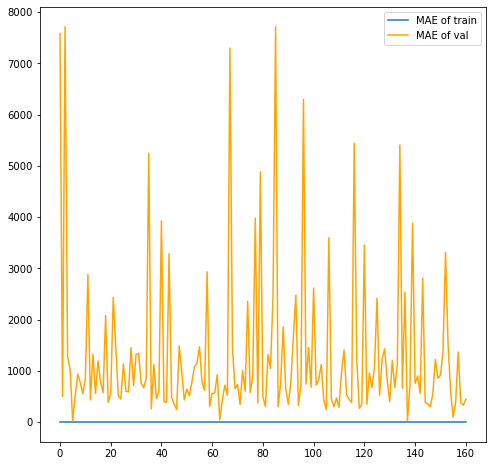

In [92]:
fig = plt.figure(figsize=(8,8))
plt.plot(MAE_of_train, label="MAE of train")
plt.plot(MAE_of_validation, label="MAE of val", color="orange")
plt.legend()

Creo que no hay sobreaprendizaje? pero hay mucha varianza en el error.
#to ask-> what to do with this conclusion?   